In [1]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint # type: ignore #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model # type: ignore #tải mô hình
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore

#các lớp để xây dựng mô hình
from keras.models import Sequential # type: ignore #đầu vào
from keras.layers import LSTM # type: ignore #học phụ thuộc
from keras.layers import Dropout # type: ignore #tránh học tủ
from keras.layers import Dense # type: ignore #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score  # Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error  # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error, f1_score  # Đo % sai số tuyệt đối trung bình

from pymongo import MongoClient

In [2]:

# Kết nối đến MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['metadata']  
collection = db['GVR']  

# Chuyển dữ liệu thành DataFrame
df = pd.DataFrame(list(collection.find({}, {"_id": 0})))
df


,Ngay,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
0,2018-03-21,9.55,10.90,515800,5719180000,0,0,15.00,15.00,9.80,-2.10,-16.15
1,2018-03-26,9.02,10.30,0,267800,50000,435000000,10.20,10.50,10.20,0.10,0.98
2,2018-03-27,9.55,10.90,52200,558660000,0,0,10.80,11.00,10.50,0.60,5.83
3,2018-03-29,10.43,11.90,587200,6930390000,4470000,52746000000,11.70,12.30,11.40,0.60,5.31
4,2018-03-30,10.78,12.30,0,540800,0,0,12.40,13.00,11.30,0.50,4.24
...,...,...,...,...,...,...,...,...,...,...,...,...
1680,2024-12-17,31.10,31.10,948600,29586000000,0,0,31.45,31.45,31.10,-0.10,-0.32
1681,2024-12-13,31.40,31.40,1142900,35966000000,0,0,31.60,31.65,31.35,-0.25,-0.79
1682,2024-12-18,31.35,31.35,762900,23807000000,0,0,31.10,31.35,31.05,0.25,0.80
1683,2024-12-19,30.90,30.90,2228300,68922000000,0,0,30.90,31.15,30.75,-0.45,-1.44


In [3]:
# Kiểm tra dữ liệu
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1685 entries, 0 to 1684
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ngay               1685 non-null   object 
 1   GiaDieuChinh       1685 non-null   float64
 2   GiaDongCua         1685 non-null   float64
 3   KhoiLuongKhopLenh  1685 non-null   int64  
 4   GiaTriKhopLenh     1685 non-null   int64  
 5   KLThoaThuan        1685 non-null   int64  
 6   GtThoaThuan        1685 non-null   int64  
 7   GiaMoCua           1685 non-null   float64
 8   GiaCaoNhat         1685 non-null   float64
 9   GiaThapNhat        1685 non-null   float64
 10  ThayDoi_GiaTri     1685 non-null   float64
 11  ThayDoi_PhanTram   1685 non-null   float64
dtypes: float64(7), int64(4), object(1)
memory usage: 158.1+ KB


,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
count,1685.000000,1685.000000,1.685000e+03,1.685000e+03,1.685000e+03,1.685000e+03,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000
mean,19.565549,20.685786,2.311275e+06,6.115679e+10,4.740938e+04,6.023992e+08,20.706231,21.122617,20.169187,0.006724,0.105549
std,9.695900,9.771284,2.152915e+06,7.053066e+10,5.478367e+05,5.203199e+09,9.790169,9.953370,9.744903,0.638502,3.017859
min,6.040000,6.900000,0.000000e+00,3.000000e+02,0.000000e+00,0.000000e+00,7.300000,7.800000,6.700000,-2.800000,-16.150000
25%,10.760000,12.100000,5.594330e+05,6.677000e+09,0.000000e+00,0.000000e+00,12.100000,12.400000,11.500000,-0.250000,-1.270000
50%,17.770000,18.550000,1.899000e+06,3.846200e+10,0.000000e+00,0.000000e+00,18.650000,18.950000,18.200000,0.000000,0.000000
75%,28.630000,29.800000,3.422100e+06,9.024200e+10,0.000000e+00,0.000000e+00,29.950000,30.700000,29.250000,0.300000,1.610000
max,39.910000,42.100000,1.585120e+07,4.984230e+11,1.010000e+07,9.999000e+10,43.300000,43.300000,40.800000,2.750000,14.470000


In [4]:
# Xử lý thời gian và sắp xếp dữ liệu
df['Ngay'] = pd.to_datetime(df['Ngay'], format='%Y-%m-%d')
df = df.sort_values(by='Ngay')

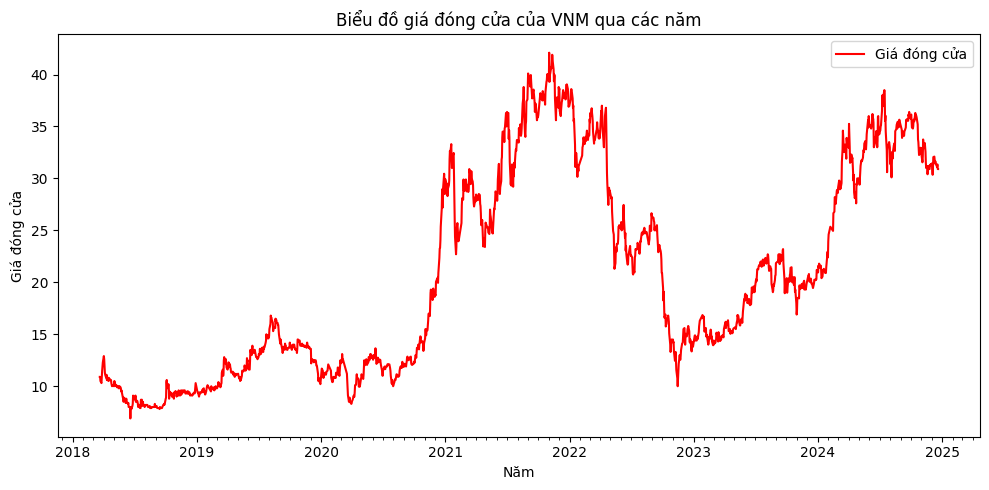

In [8]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Lấy thông tin năm từ cột "Ngày"
df['Nam'] = df['Ngay'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Ngay'], df['GiaDongCua'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của VNM qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()

In [9]:
# Chuyển đổi sang chỉ số thời gian
df1 = pd.DataFrame(df, columns=['Ngay', 'GiaDongCua'])
df1.index = df1['Ngay']
df1.drop('Ngay', axis=1, inplace=True)

In [10]:
df1

,GiaDongCua
Ngay,
2018-03-21,10.90
2018-03-22,10.90
2018-03-23,10.50
2018-03-26,10.30
2018-03-27,10.90
...,...
2024-12-16,31.20
2024-12-17,31.10
2024-12-18,31.35


In [11]:
# Chia tập dữ liệu
data = df1.values
train_data = data[:int(len(df) * 0.8)]
test_data = data[int(len(df) * 0.8):]

In [12]:
data

array([[10.9 ],
       [10.9 ],
       [10.5 ],
       ...,
       [31.35],
       [30.9 ],
       [30.9 ]])

In [13]:
# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(data)

In [14]:
# Tạo cửa sổ thời gian cho tập train
x_train, y_train = [], []
for i in range(50, len(train_data)):
    x_train.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_train.append(sc_train[i, 0])  # Giá trị tiếp theo
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [15]:
# Tạo cửa sổ thời gian cho tập test
x_test, y_test = [], []
for i in range(50, len(test_data)):
    x_test.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_test.append(sc_train[i, 0])  # Giá trị tiếp theo
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

C:\Users\TRUONG\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100

Epoch 1: loss improved from inf to 0.20093, saving model to save_models/GVR_model.keras
21/21 - 10s - 470ms/step - loss: 0.2009 - val_loss: 0.0933
Epoch 2/100

Epoch 2: loss improved from 0.20093 to 0.13171, saving model to save_models/GVR_model.keras
21/21 - 1s - 59ms/step - loss: 0.1317 - val_loss: 0.0713
Epoch 3/100

Epoch 3: loss improved from 0.13171 to 0.11120, saving model to save_models/GVR_model.keras
21/21 - 1s - 58ms/step - loss: 0.1112 - val_loss: 0.0597
Epoch 4/100

Epoch 4: loss improved from 0.11120 to 0.09727, saving model to save_models/GVR_model.keras
21/21 - 1s - 56ms/step - loss: 0.0973 - val_loss: 0.0534
Epoch 5/100

Epoch 5: loss improved from 0.09727 to 0.08680, saving model to save_models/GVR_model.keras
21/21 - 1s - 59ms/step - loss: 0.0868 - val_loss: 0.0454
Epoch 6/100

Epoch 6: loss improved from 0.08680 to 0.08254, saving model to save_models/GVR_model.keras
21/21 - 1s - 56ms/step - loss: 0.0825 - val_loss: 0.0395
Epoch 7/100

Epoch 7: loss imp

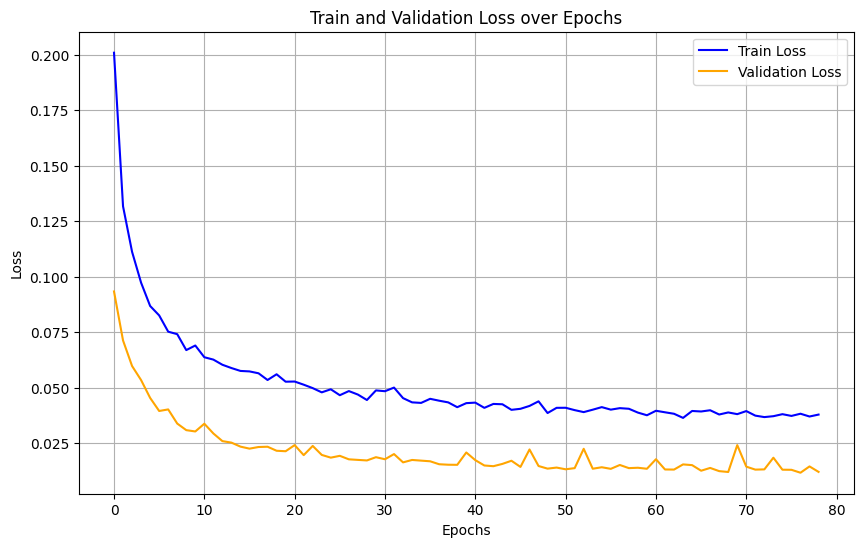

In [13]:
def build_model(input_shape):
    model = Sequential()
    
    # Giảm số đơn vị trong LSTM và tăng regularization
    model.add(LSTM(units=64, input_shape=input_shape, return_sequences=True, 
                   kernel_regularizer=l2(0.001)))
    model.add(LSTM(units=32, kernel_regularizer=l2(0.001)))
    
    # Tăng Dropout để giảm overfitting
    model.add(Dropout(0.4))
    
    # Lớp Dense để đưa ra kết quả dự đoán
    model.add(Dense(1))
    
    # Compile mô hình
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001))
    return model

# Xây dựng mô hình
input_shape = (x_train.shape[1], x_train.shape[2])
model = build_model(input_shape)

# Đường dẫn lưu mô hình
save_model_path = "save_models/GVR_model.keras"

# Callbacks: ModelCheckpoint và EarlyStopping
callbacks = [
    ModelCheckpoint(save_model_path, monitor='loss', verbose=2, save_best_only=True, mode='auto'),
    EarlyStopping(monitor='loss', patience=15, restore_best_weights=True, verbose=2)
]

# Huấn luyện mô hình và lưu kết quả vào history
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),  # Thêm tập validation
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=callbacks
)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')  # Thêm val_loss
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
save_model_path = "models/GVR_model.keras"
# Tải mô hình tốt nhất
final_model = load_model(save_model_path)

In [17]:
# Dự đoán trên tập train
y_train_predict = final_model.predict(x_train)
y_train_predict = sc.inverse_transform(y_train_predict)
y_train = sc.inverse_transform(y_train.reshape(-1, 1))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [18]:
#xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[int(len(df) * 0.8):] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


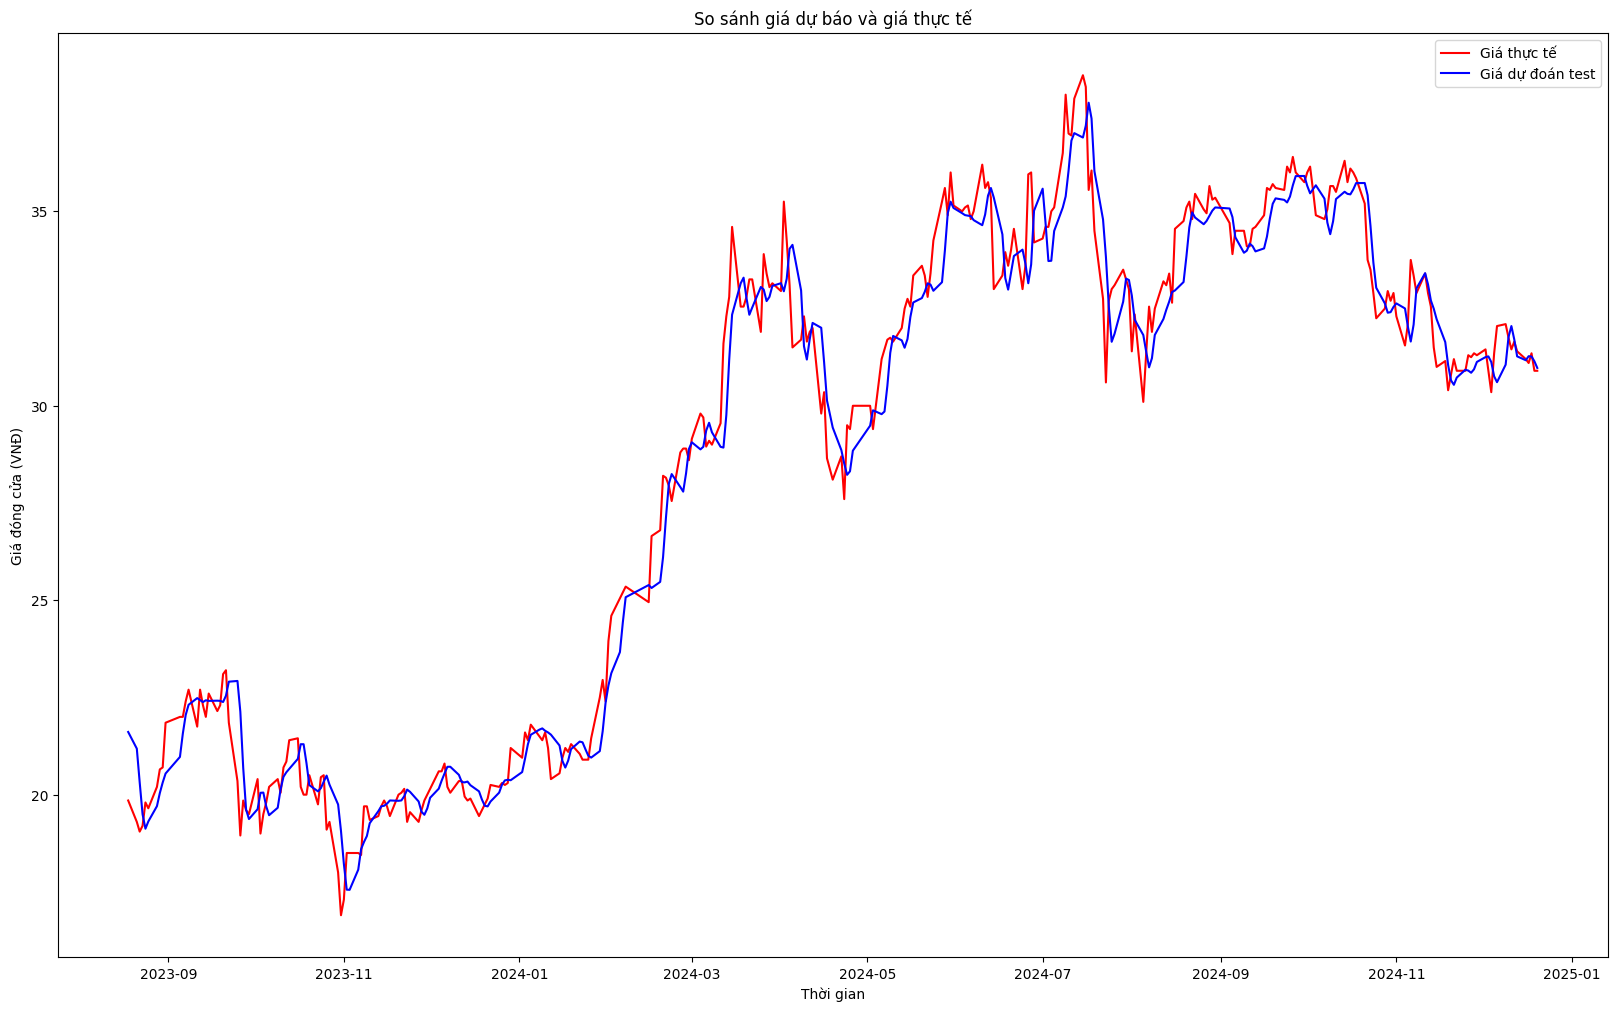

In [20]:
# Chọn dữ liệu cho test_data1
num_test_predictions = len(y_test_predict)
test_data1 = df.iloc[-num_test_predictions:].copy()
plt.figure(figsize=(20, 12))
if 'Ngay' in test_data1.columns:
    plt.plot(test_data1['Ngay'], test_data1['GiaDongCua'], label='Giá thực tế', color='red')
else:
    raise KeyError("Cột 'Ngày' không tồn tại trong test_data1.")

test_data1 = test_data1.copy()
test_data1['Dự đoán'] = y_test_predict.flatten()
plt.plot(test_data1['Ngay'], test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.title('So sánh giá dự báo và giá thực tế')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.legend()
plt.show()


In [18]:
print('--- Kết quả trên tập train ---')
# R2 score
print('Độ phù hợp tập train (R2):', r2_score(y_train, y_train_predict))

# MAE
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):', mean_absolute_error(y_train, y_train_predict))

# MAPE
print('Phần trăm sai số tuyệt đối trung bình trên tập train:', mean_absolute_percentage_error(y_train, y_train_predict) * 100)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predict))
print('RMSE trên tập train (VNĐ):', rmse_train)

# Accuracy (dựa trên RMSE và biên độ giá trị thực tế)
range_y_train = np.max(y_train) - np.min(y_train)
accuracy_train = 1 - (rmse_train / range_y_train)
print('Độ chính xác trên tập train (%):', accuracy_train * 100)

# F1 Score (Chuyển thành bài toán phân loại)
error_threshold = 10  # Ngưỡng sai số
y_train_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_train, y_train_predict)]
y_train_pred_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_train, y_train_predict)]
f1_train = f1_score(y_train_class, y_train_pred_class)
print('F1 Score trên tập train:', f1_train)
print("----------------------------------------------------")

--- Kết quả trên tập train ---
Độ phù hợp tập train (R2): 0.9884526678539598
Sai số tuyệt đối trung bình trên tập train (VNĐ): 0.7104058762360794
Phần trăm sai số tuyệt đối trung bình trên tập train: 3.9450415785582185
RMSE trên tập train (VNĐ): 1.0231225826280104
Độ chính xác trên tập train (%): 97.0934017538977
F1 Score trên tập train: 1.0
----------------------------------------------------


In [19]:
y_test = data[-len(y_test_predict):]

In [20]:
print('--- Kết quả trên tập test ---')
# R2 score
print('Độ phù hợp tập test (R2):', r2_score(y_test, y_test_predict))

# MAE
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mean_absolute_error(y_test, y_test_predict))

# MAPE
print('Phần trăm sai số tuyệt đối trung bình trên tập test:', mean_absolute_percentage_error(y_test, y_test_predict) * 100)

# RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
print('RMSE trên tập test (VNĐ):', rmse_test)

# Accuracy (dựa trên RMSE và biên độ giá trị thực tế)
range_y_test = np.max(y_test) - np.min(y_test)
accuracy_test = 1 - (rmse_test / range_y_test)
print('Độ chính xác trên tập test (%):', accuracy_test * 100)

# F1 Score (Chuyển thành bài toán phân loại)
y_test_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_test, y_test_predict)]
y_test_pred_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_test, y_test_predict)]
f1_test = f1_score(y_test_class, y_test_pred_class)
print('F1 Score trên tập test:', f1_test)
print("----------------------------------------------------")

--- Kết quả trên tập test ---
Độ phù hợp tập test (R2): 0.9710931173592785
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.8137538219417944
Phần trăm sai số tuyệt đối trung bình trên tập test: 2.9164859257781957
RMSE trên tập test (VNĐ): 1.0732009167951313
Độ chính xác trên tập test (%): 95.03147723705958
F1 Score trên tập test: 1.0
----------------------------------------------------


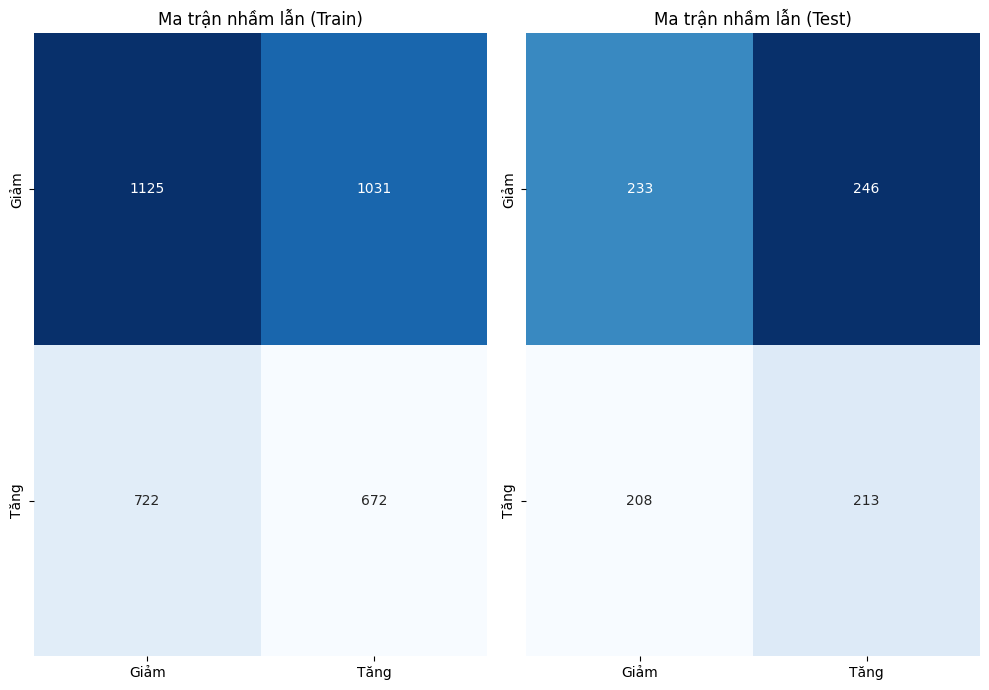

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def create_labels(data):
    return [1 if data[i] > data[i-1] else 0 for i in range(1, len(data))]

# Chuyển đổi giá trị thực tế và dự đoán thành nhãn phân loại
y_train_labels = create_labels(y_train)
y_train_predict_labels = create_labels(y_train_predict.flatten())

y_test_labels = create_labels(y_test)
y_test_predict_labels = create_labels(y_test_predict.flatten())

# Tạo ma trận nhầm lẫn cho tập train
cm_train = confusion_matrix(y_train_labels, y_train_predict_labels)
cm_test = confusion_matrix(y_test_labels, y_test_predict_labels)

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(10, 7))

# Ma trận nhầm lẫn cho tập train
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Giảm", "Tăng"], yticklabels=["Giảm", "Tăng"])
plt.title("Ma trận nhầm lẫn (Train)")

# Ma trận nhầm lẫn cho tập test
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Giảm", "Tăng"], yticklabels=["Giảm", "Tăng"])
plt.title("Ma trận nhầm lẫn (Test)")

plt.tight_layout()
plt.show()